In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Mean-Variance Optimization

In [2]:
data = pd.read_excel('multi_asset_etf_data.xlsx', sheet_name= 'excess returns')
data = data.set_index('Date')
data.head()

,BWX,DBC,EEM,EFA,HYG,IEF,IYR,PSP,QAI,SPY,TIP
Date,,,,,,,,,,,
2011-02-28,0.006527,0.041620,-0.000527,0.035408,0.014264,-0.002174,0.045113,0.040056,0.002493,0.034647,0.007118
2011-03-31,0.008255,0.026409,0.062723,-0.024055,0.000251,-0.001719,-0.011107,0.016495,0.005348,-0.000052,0.011730
2011-04-30,0.048261,0.045015,0.026783,0.055715,0.015432,0.017868,0.046089,0.058127,0.018490,0.028418,0.023236
2011-05-31,-0.013447,-0.051625,-0.029301,-0.021962,0.001432,0.025156,0.010233,-0.041465,0.000099,-0.011115,0.002758
2011-06-30,-0.000270,-0.042817,-0.009528,-0.012280,-0.005878,-0.005217,-0.031233,-0.042754,-0.010948,-0.017042,0.007377


### Summary Statistics

In [3]:
summary = data.describe()
summary = summary.iloc[1:3,]
summary.loc['mean'] = summary.loc['mean']*12
summary.loc['std'] = summary.loc['std']*12**0.5
summary.loc['Sharpe Ratio'] = summary.loc['mean']/summary.loc['std']
summary

,BWX,DBC,EEM,EFA,HYG,IEF,IYR,PSP,QAI,SPY,TIP
mean,-0.011888,-0.009086,0.026960,0.055037,0.037356,0.013939,0.077912,0.092851,0.014959,0.126983,0.016844
std,0.081671,0.168455,0.179940,0.152203,0.077289,0.063197,0.169585,0.215238,0.049007,0.143066,0.051258
Sharpe Ratio,-0.145563,-0.053935,0.149829,0.361605,0.483335,0.220561,0.459426,0.431386,0.305241,0.887578,0.328618


In [4]:
best_sharpe_ratio = summary.loc[:,summary.loc['Sharpe Ratio'].idxmax()]
worst_sharpe_ratio = summary.loc[:,summary.loc['Sharpe Ratio'].idxmin()]
print('Highest Sharpe Ratio')
print(best_sharpe_ratio)
print('\nLowest Sharpe Ratio')
print(worst_sharpe_ratio)

Highest Sharpe Ratio
mean            0.126983
std             0.143066
Sharpe Ratio    0.887578
Name: SPY, dtype: float64

Lowest Sharpe Ratio
mean           -0.011888
std             0.081671
Sharpe Ratio   -0.145563
Name: BWX, dtype: float64


### Descriptive Analysis

<Axes: >

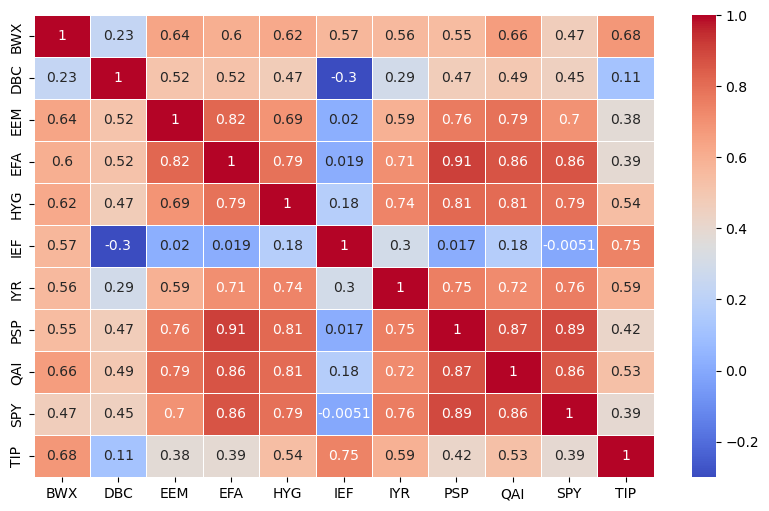

In [5]:
corr_matrix = data.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

In [6]:
corr_unstacked = corr_matrix.unstack()
corr_unstacked = corr_unstacked[corr_unstacked.index.get_level_values(0) != corr_unstacked.index.get_level_values(1)]
max_corr_pair = corr_unstacked.idxmax(), corr_unstacked.max()
min_corr_pair = corr_unstacked.idxmin(), corr_unstacked.min()
print(f'Highest Correlation:  {max_corr_pair}') 
print(f'Lowest Correlation: {min_corr_pair}')

Highest Correlation:  (('EFA', 'PSP'), 0.9105956995777845)
Lowest Correlation: (('DBC', 'IEF'), -0.30052272295503085)


In [7]:
summary[['TIP','IEF', 'HYG','BWX']]

,TIP,IEF,HYG,BWX
mean,0.016844,0.013939,0.037356,-0.011888
std,0.051258,0.063197,0.077289,0.081671
Sharpe Ratio,0.328618,0.220561,0.483335,-0.145563


Domestic Bonds: 'IEF', 'HYG'
Foreign Bonds: BWX

TIPS have outprefeormed domestic bond IEF and foreign bond BWX. Domestic bond HYG outpreformed TIP.

### MV Frontier

In [8]:
mu = data.mean()
cov_matrix = data.cov()
ones = np.ones(len(mu))

# Calculate tengency portfolios weights
inv_cov = np.linalg.inv(cov_matrix)
wt = inv_cov @ mu / (ones.T @ inv_cov @ mu)

# Calculate stats for tangency portfolio
mean_tan = wt.T @ mu
vol_tan = np.sqrt(wt.T @ cov_matrix @ wt)
sharpe_tan = mean_tan / vol_tan

# Display results
print("Tangency Portfolio Weights:")
print(pd.Series(wt, index=data.columns))

print(f"\nTangency Portfolio Mean: {mean_tan}")
print(f"Tangency Portfolio Volatility: {vol_tan}")
print(f"Tangency Portfolio Sharpe Ratio: {sharpe_tan}")

# Compare the ranking of tangency portfolio weights with individual Sharpe ratios
individual_sharpe_ratios = mu / np.sqrt(np.diag(cov_matrix))
weights_ranking = pd.Series(wt, index=data.columns).rank(ascending=False)
sharpe_ranking = pd.Series(individual_sharpe_ratios, index=data.columns).rank(ascending=False)

comparison = pd.DataFrame({
    'Tangency Portfolio Weights': wt,
    'Weights Ranking': weights_ranking,
    'Sharpe Ratio': individual_sharpe_ratios,
    'Sharpe Ratio Ranking': sharpe_ranking
})

# Sort by weights ranking
comparison_sorted = comparison.sort_values(by='Weights Ranking')
comparison_sorted

Tangency Portfolio Weights:
BWX    2.730253
DBC   -0.111241
EEM   -0.615698
EFA    0.530692
HYG   -0.832578
IEF   -4.682480
IYR    0.877108
PSP    0.277002
QAI    7.220592
SPY   -4.904086
TIP    0.510436
dtype: float64

Tangency Portfolio Mean: -0.043939664204956055
Tangency Portfolio Volatility: 0.09483363089786331
Tangency Portfolio Sharpe Ratio: -0.4633341968344487


,Tangency Portfolio Weights,Weights Ranking,Sharpe Ratio,Sharpe Ratio Ranking
QAI,7.220592,1.0,0.088116,7.0
BWX,2.730253,2.0,-0.042020,11.0
IYR,0.877108,3.0,0.132625,3.0
EFA,0.530692,4.0,0.104386,5.0
TIP,0.510436,5.0,0.094864,6.0
PSP,0.277002,6.0,0.124531,4.0
DBC,-0.111241,7.0,-0.015570,10.0
EEM,-0.615698,8.0,0.043252,9.0
HYG,-0.832578,9.0,0.139527,2.0
IEF,-4.682480,10.0,0.063671,8.0


The ranking of the weights does not align with the Sharpe Ratio ranking.

### TIPS

In [9]:
data_no_tips = data.drop(columns=['TIP'])

mu_no_tips = data_no_tips.mean()
cov_matrix_no_tips = data_no_tips.cov()
inv_cov_matrix_no_tips = np.linalg.inv(cov_matrix_no_tips)
weights_tangency_no_tips = inv_cov_matrix_no_tips @ mu_no_tips / (ones[:-1].T @ inv_cov_matrix_no_tips @ mu_no_tips)

mean_tan_no_tips = weights_tangency_no_tips.T @ mu_no_tips
vol_tan_no_tips = np.sqrt(weights_tangency_no_tips.T @ cov_matrix_no_tips @ weights_tangency_no_tips)
sharpe_tan_no_tips = mean_tan_no_tips / vol_tan_no_tips

print("Tangency Portfolio Weights:")
print(pd.Series(weights_tangency_no_tips, index=data_no_tips.columns))

print(f"\nTangency Portfolio Mean: {mean_tan_no_tips}")
print(f"Tangency Portfolio Volatility: {vol_tan_no_tips}")
print(f"Tangency Portfolio Sharpe Ratio: {sharpe_tan_no_tips}")


Tangency Portfolio Weights:
BWX    3.015911
DBC   -0.090968
EEM   -0.664230
EFA    0.540606
HYG   -0.871637
IEF   -4.832385
IYR    0.990156
PSP    0.324898
QAI    7.976911
SPY   -5.389260
dtype: float64

Tangency Portfolio Mean: -0.04840046380293057
Tangency Portfolio Volatility: 0.1045364822507755
Tangency Portfolio Sharpe Ratio: -0.463000693736961


In [10]:
mu_adjusted_tips = mu.copy()
mu_adjusted_tips['TIP'] += 0.0012

weights_tangency_adjusted_tips = inv_cov @ mu_adjusted_tips / (ones.T @ inv_cov @ mu_adjusted_tips)

mean_tan_adjusted_tips = weights_tangency_adjusted_tips.T @ mu_adjusted_tips
vol_tan_adjusted_tips = np.sqrt(weights_tangency_adjusted_tips.T @ cov_matrix @ weights_tangency_adjusted_tips)
sharpe_tan_adjusted_tips = mean_tan_adjusted_tips / vol_tan_adjusted_tips

print("Tangency Portfolio Weights:")
print(pd.Series(weights_tangency_adjusted_tips, index=data.columns))

print(f"\nTangency Portfolio Mean: {mean_tan}")
print(f"Tangency Portfolio Volatility: {vol_tan}")
print(f"Tangency Portfolio Sharpe Ratio: {sharpe_tan}")


Tangency Portfolio Weights:
BWX    29.260095
DBC     1.771624
EEM    -5.123028
EFA     1.451443
HYG    -4.460119
IEF   -18.604613
IYR    11.376147
PSP     4.725247
QAI    77.462118
SPY   -49.963644
TIP   -46.895270
dtype: float64

Tangency Portfolio Mean: -0.043939664204956055
Tangency Portfolio Volatility: 0.09483363089786331
Tangency Portfolio Sharpe Ratio: -0.4633341968344487


# Allocations

In [11]:
mu = data.mean()  
cov_matrix = data.cov() 

n_assets = len(mu)

# Equally-Weighted (EW) Portfolio
w_ew = np.ones(n_assets) / n_assets  

# Risk-Parity (RP) Portfolio
variances = np.diag(cov_matrix) 
w_rp = 1 / variances  
w_rp = w_rp / w_rp.sum()  

# Regularized (REG) Portfolio
diag_variances = np.diag(variances)
cov_matrix_regularized = (cov_matrix + diag_variances) / 2
inv_cov_matrix_reg = np.linalg.inv(cov_matrix_regularized)
w_reg = inv_cov_matrix_reg @ mu
w_reg = w_reg / w_reg.sum()  

weights_df = pd.DataFrame({
    'Equally-Weighted': w_ew,
    'Risk-Parity': w_rp,
    'Regularized': w_reg
}, index=data.columns)

weights_df

,Equally-Weighted,Risk-Parity,Regularized
BWX,0.090909,0.094934,-0.855638
DBC,0.090909,0.022315,-0.172547
EEM,0.090909,0.019557,-0.083825
EFA,0.090909,0.027335,0.047259
HYG,0.090909,0.106005,0.401333
IEF,0.090909,0.158552,0.498538
IYR,0.090909,0.022018,0.101704
PSP,0.090909,0.013669,0.062771
QAI,0.090909,0.263663,-0.198272
SPY,0.090909,0.030937,0.790188


In [12]:
mu_target = 0.01 

# Tangency Portfolio (from previous section)
inv_cov_matrix = np.linalg.inv(cov_matrix)
w_tan = inv_cov_matrix @ mu / (np.ones(len(mu)).T @ inv_cov_matrix @ mu)

# Function to rescale weights to target mean return
def rescale_weights(weights, mu, mu_target):
    portfolio_mean = weights.T @ mu
    scaling_factor = mu_target / portfolio_mean
    return weights * scaling_factor

# Function to calculate portfolio statistics
def portfolio_performance(weights, mu, cov_matrix):
    mean_return = weights.T @ mu
    volatility = np.sqrt(weights.T @ cov_matrix @ weights)
    sharpe_ratio = mean_return / volatility
    return mean_return, volatility, sharpe_ratio

# Rescale all portfolios to have target mean return
w_ew_scaled = rescale_weights(w_ew, mu, mu_target)
w_rp_scaled = rescale_weights(w_rp, mu, mu_target)
w_reg_scaled = rescale_weights(w_reg, mu, mu_target)
w_tan_scaled = rescale_weights(w_tan, mu, mu_target)

# Calculate performance metrics for each portfolio
performance_ew = portfolio_performance(w_ew_scaled, mu, cov_matrix)
performance_rp = portfolio_performance(w_rp_scaled, mu, cov_matrix)
performance_reg = portfolio_performance(w_reg_scaled, mu, cov_matrix)
performance_tan = portfolio_performance(w_tan_scaled, mu, cov_matrix)

performance_df = pd.DataFrame({
    'Portfolio': ['Equally-Weighted', 'Risk-Parity', 'Regularized', 'Tangency'],
    'Mean Return': [performance_ew[0], performance_rp[0], performance_reg[0], performance_tan[0]],
    'Volatility': [performance_ew[1], performance_rp[1], performance_reg[1], performance_tan[1]],
    'Sharpe Ratio': [performance_ew[2], performance_rp[2], performance_reg[2], performance_tan[2]]
})
performance_df

,Portfolio,Mean Return,Volatility,Sharpe Ratio
0,Equally-Weighted,0.01,0.084157,0.118826
1,Risk-Parity,0.01,0.089349,0.111920
2,Regularized,0.01,0.029619,0.337617
3,Tangency,0.01,0.021583,0.463334


Out-of-Sample Performance

In [37]:
# Split data into in and out sample
in_data = data.loc[:'2022-12']
out_data = data.loc['2023-01':]

# Calculate mean and cov matrix
mean_in = in_data.mean()
cov_in = in_data.cov()

# Calculate weights for equal weight
ew_in = np.ones(n_assets) / n_assets

# Calculate weights for risk parity
rp_in = 1 / np.diag(cov_in)
rp_in = rp_in / rp_in.sum()

# Calculate weights for reg
cov_r = (cov_in + np.diag(cov_in)) / 2
reg_in = np.linalg.inv(cov_r) @ mean_in
reg_in = reg_in / reg_in.mean()

ew_in_scaled = rescale_weights(ew_in, mean_in, mu_target)
rp_in_scaled = rescale_weights(rp_in, mean_in, mu_target)
reg_in_scaled = rescale_weights(reg_in, mean_in, mu_target)

def performance(w, mean, cov):
    mean_return = w.T @ mean
    volatility = np.sqrt(w.T @ cov @ w)
    return mean_return / volatility

print("EW:")
print("Sharpe_ratio of in sample = " + str(performance(ew_in_scaled, mean_in, cov_in)))
print("RP:")
print("Sharpe_ratio of in sample = " + str(performance(ew_in_scaled, mean_in, cov_in)))
print("REG:")
print("Sharpe_ratio of in sample = " + str(performance(ew_in_scaled, mean_in, cov_in)))

EW:
Sharpe_ratio of in sample = 0.10429121037459016
RP:
Sharpe_ratio of in sample = 0.10429121037459016
REG:
Sharpe_ratio of in sample = 0.10429121037459016


In [38]:
mean_out = out_data.mean()
cov_out = out_data.cov()

print("EW:")
print("Sharpe_ratio of out sample = " + str(performance(ew_in_scaled, mean_out, cov_out)))
print("RP:")
print("Sharpe_ratio of out sample = " + str(performance(rp_in_scaled, mean_out, cov_out)))
print("REG:")
print("Sharpe_ratio of out sample = " + str(performance(reg_in_scaled, mean_out, cov_out)))


EW:
Sharpe_ratio of out sample = 0.2134167449211304
RP:
Sharpe_ratio of out sample = 0.13521081462191362
REG:
Sharpe_ratio of out sample = 0.22950908768253822


Rolling OOS Performance

In [42]:
start = '2015-12'
end = '2016-01'
perform = pd.DataFrame(columns = ["Tangency (in)", "Tangency (out)", "EW (in)", "EW (out)", "RP (in)", "RP (out)", "REG (in)", "REG (out)"])
while start != '2024-12':
    # Split data into in and out sample
    in_data = data.loc[:start]
    out_data = data.loc[end:]

    # Calculate mean and cov matrix
    mean_in = in_data.mean()
    cov_in = in_data.cov()
    inv_cov_in = np.linalg.inv(cov_in)

    # Calculate weights for tengency
    inv_cov_in = np.linalg.inv(cov_in)
    tan_in = inv_cov_in @ mean_in / (np.ones(len(mean_in)).T @ inv_cov_in @ mean_in)

    # Calculate weights for equal weight
    ew_in = np.ones(n_assets) / n_assets

    # Calculate weights for risk parity
    rp_in = 1 / np.diag(cov_in)
    rp_in = rp_in / rp_in.sum()

    # Calculate weights for reg
    cov_r = (cov_in + np.diag(cov_in)) / 2
    reg_in = np.linalg.inv(cov_r) @ mean_in
    reg_in = reg_in / reg_in.mean()

    tan_in_scaled = rescale_weights(tan_in, mean_in, mu_target)
    ew_in_scaled = rescale_weights(ew_in, mean_in, mu_target)
    rp_in_scaled = rescale_weights(rp_in, mean_in, mu_target)
    reg_in_scaled = rescale_weights(reg_in, mean_in, mu_target)

    d = dict()
    mean_out = out_data.mean()
    cov_out = out_data.cov()

    d["Tangency (in)"]=performance(tan_in_scaled, mean_in, cov_in)
    d["Tangency (out)"]=performance(tan_in_scaled, mean_out, cov_out)
    d["EW (in)"]=performance(ew_in_scaled, mean_in, cov_in)
    d["EW (out)"]=performance(ew_in_scaled, mean_out, cov_out)
    d["RP (in)"]=performance(rp_in_scaled, mean_in, cov_in)
    d["RP (out)"]=performance(rp_in_scaled, mean_out, cov_out)
    d["REG (in)"]=performance(reg_in_scaled, mean_in, cov_in)
    d["REG (out)"]=performance(reg_in_scaled, mean_out, cov_out)

    perform = perform._append(d, ignore_index = True)

    start = str(np.datetime64(start) + np.timedelta64(1,'Y'))
    end = str(np.datetime64(end) + np.timedelta64(1,'Y'))

perform

C:\Users\James Chen\AppData\Local\Temp\ipykernel_7360\3389211982.py:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  perform = perform._append(d, ignore_index = True)


,Tangency (in),Tangency (out),EW (in),EW (out),RP (in),RP (out),REG (in),REG (out)
0,0.860675,0.228012,0.087348,0.133953,0.171893,0.084008,0.643113,0.144492
1,0.845288,0.236151,0.115569,0.121394,0.187685,0.077355,0.553739,0.150883
2,0.857784,0.220205,0.168274,0.085870,0.233502,0.045680,0.540109,0.122134
3,0.720022,0.221210,0.110727,0.130287,0.167115,0.078309,0.516039,0.145641
4,0.718187,0.174712,0.156419,0.080868,0.212433,0.022781,0.523125,0.085312
5,0.683353,0.044102,0.147468,0.056423,0.219488,-0.065198,0.501747,-0.071289
6,0.643782,0.035562,0.170857,-0.027946,0.221254,-0.113040,0.450266,-0.046550
7,0.480196,0.288304,0.104291,0.213417,0.104755,0.135211,0.372511,0.229509
8,0.456233,0.533909,0.110263,0.364085,0.106045,0.218071,0.372606,0.450362


'2024-12'